# Imports

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_absolute_error
%matplotlib inline

# Data reading

In [27]:
df=pd.read_csv('data.csv')
df.head()

,score,genre,Actors,Titles
0,73.0,"Drama, Action","Michael B. Jordan, Adonis Creed, Tessa Thompso...",Creed III
1,78.0,"Science Fiction, Adventure, Action","Sam Worthington, Jake Sully, Zoe Saldaña, Neyt...",Avatar: The Way of Water
2,76.0,"Animation, Adventure, Family, Fantasy, Comedy","Chris Pratt, Mario (voice), Anya Taylor-Joy, P...",The Super Mario Bros. Movie
3,70.0,"Animation, Comedy, Family, Adventure, Fantasy","Óscar Barberán, Thut (voice), Ana Esther Albor...",Momias
4,61.0,Action,"Skeet Ulrich, Roy Cameron, Anne Heche, Dr Quin...",Supercell


In [28]:
df.isnull().sum()

,0
score,0
genre,0
Actors,0
Titles,0


In [29]:
df.duplicated().sum()

0

In [30]:
df.columns

Index(['score', 'genre', 'Actors', 'Titles'], dtype='object')

# Visualizations
`PIE :-`

<Axes: ylabel='count'>

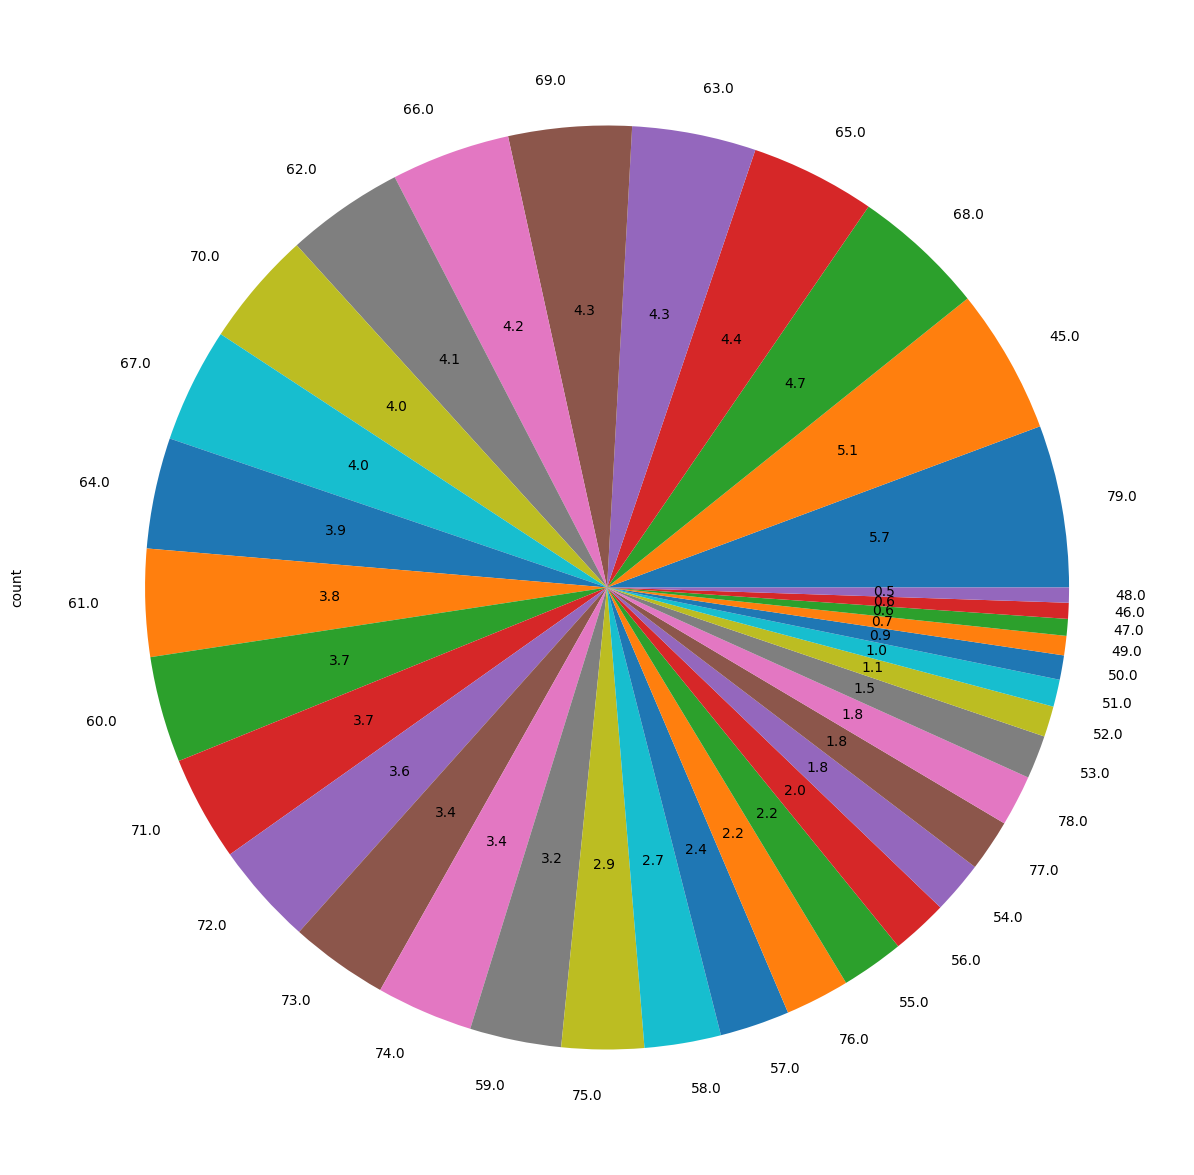

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
df['score'].value_counts().plot(kind='pie',autopct='%1.1f')

`HISTOGRAM :-`

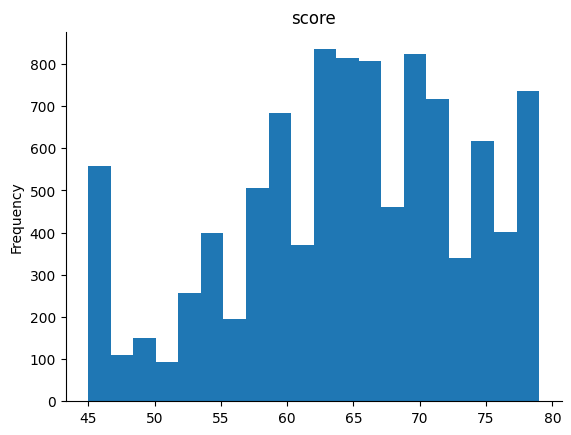

In [32]:
df['score'].plot(kind='hist', bins=20, title='score')
plt.gca().spines[['top', 'right',]].set_visible(False)

# Train Test Split

In [33]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Matrix Factorization :
- `Create user-item matrix for training data`
- `Perform SVD on the training data`

In [34]:
train_user_item_matrix = pd.pivot_table(train_df, index='Titles', columns='Actors', values='score').fillna(0)
train_user_item_matrix_sparse = csr_matrix(train_user_item_matrix)

U, s, Vt = svds(train_user_item_matrix_sparse, k=50)
sigma = np.diag(s)
predicted_ratings = np.dot(np.dot(U, sigma), Vt)
predicted_ratings_df = pd.DataFrame(predicted_ratings, index=train_user_item_matrix.index, columns=train_user_item_matrix.columns)

# Function :
- `Matrix Factorization Recommendation Function`

In [35]:
def matrix_factorization_recommendations(movie_title, num_recommendations=5):
    predicted_ratings_for_movie = predicted_ratings_df.loc[movie_title].sort_values(ascending=False)
    predicted_ratings_for_movie = predicted_ratings_for_movie.drop(movie_title, errors='ignore')
    return predicted_ratings_for_movie.head(num_recommendations)

# Content-Based Filtering (using genre and actors) :
- `Create a combined feature column for content-based filtering`
- `Calculate cosine similarity between movies based on combined features`

In [36]:
df['combined_features'] = df['genre'] + ' ' + df['Actors']

tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['combined_features'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_df = pd.DataFrame(cosine_sim, index=df['Titles'], columns=df['Titles'])

# Function :
- `Content-Based Filtering Recommendation Function`
- ` Hybrid Approach (Combining Matrix Factorization and Content-Based Filtering)`

In [37]:
def content_based_recommendations(movie_title, num_recommendations=5):
    similarity_scores = cosine_sim_df[movie_title].sort_values(ascending=False)
    similarity_scores = similarity_scores.drop(movie_title, errors='ignore')
    return similarity_scores.head(num_recommendations)

def hybrid_recommendations(movie_title, num_recommendations=5, alpha=0.5):
    mf_recs = matrix_factorization_recommendations(movie_title, num_recommendations * 2)
    cb_recs = content_based_recommendations(movie_title, num_recommendations * 2)
    hybrid_scores = alpha * mf_recs + (1 - alpha) * cb_recs
    hybrid_scores = hybrid_scores.sort_values(ascending=False)
    return hybrid_scores.head(num_recommendations)

# Evaluation :
- `for Matrix Factorization`
- `Calculate RMSE or MAE for evaluation`

In [38]:

def evaluate_matrix_factorization(test_df):
    test_user_item_matrix = pd.pivot_table(test_df, index='Titles', columns='Actors', values='score').fillna(0)
    test_user_item_matrix_sparse = csr_matrix(test_user_item_matrix)
    U_test, s_test, Vt_test = svds(test_user_item_matrix_sparse, k=50)
    sigma_test = np.diag(s_test)
    predicted_ratings_test = np.dot(np.dot(U_test, sigma_test), Vt_test)
    predicted_ratings_test_df = pd.DataFrame(predicted_ratings_test, index=test_user_item_matrix.index, columns=test_user_item_matrix.columns)
    rmse = np.sqrt(mean_squared_error(test_user_item_matrix.values, predicted_ratings_test_df.values))
    mae = mean_absolute_error(test_user_item_matrix.values, predicted_ratings_test_df.values)
    return rmse, mae

# Example usage and evaluation :

In [39]:
unique_movie_titles = df['Titles'].unique()
if len(unique_movie_titles) > 0:
    # Ensure movie_title_to_recommend is in predicted_ratings_df index
    movie_title_to_recommend = unique_movie_titles[0]
    while movie_title_to_recommend not in predicted_ratings_df.index:
        if len(unique_movie_titles) <= 1:  # avoid infinite loop when all titles not in index
            print("No movies titles are present in the predicted ratings df")
            break
        unique_movie_titles = unique_movie_titles[1:]
        movie_title_to_recommend = unique_movie_titles[0]

    if movie_title_to_recommend in predicted_ratings_df.index:
        print("Matrix Factorization Recommendations:")
        print(matrix_factorization_recommendations(movie_title_to_recommend))
        print("\nContent-Based Recommendations:")
        print(content_based_recommendations(movie_title_to_recommend))
        print("\nHybrid Recommendations:")
        print(hybrid_recommendations(movie_title_to_recommend))
        rmse, mae = evaluate_matrix_factorization(test_df)
        print("\nMatrix Factorization Evaluation:")
        print(f"RMSE: {rmse}")
        print(f"MAE: {mae}")

else:
    print("No unique movie titles found in the dataset.")

Matrix Factorization Recommendations:
Actors
Josephine Langford, Tessa Young, Hero Fiennes Tiffin, Hardin Scott, Shane Paul McGhie, Landon Gibson, Khadijha Red Thunder, Steph Jones, Dylan Arnold, Noah Porter, Samuel Larsen, Zed Evans, Inanna Sarkis, Molly Samuels, Selma Blair, Carol Young, Pia Mia, Tristan    2.864923e-16
Louise Chevillotte, Félicie, Majd Mastoura, Saïd, Natalia Wiszniewska, Kasia, Killian Briot, Sacha, Olivier Chantreau, Ivan, Juliette Gharbi, Hannah, Romain Gillot, Yann, Laura Mélinand, Sarah's Friend, Barbara Rollet, Kasia's Lover                                  2.387436e-16
Steven Strait, Freddy, Karolina Wydra, Ana, Sandra Ellis Lafferty, Aunt Lu, Ric Reitz, Doctor, Jackson Walker, Phil, Madison Lintz, Young Ana, Bob Penny, Elderly Man, April Billingsley, Caretaker, Jennifer Spriggs, Nurse                                              2.228273e-16
George Clooney, Danny Ocean, Matt Damon, Linus Caldwell, Andy García, Terry Benedict, Brad Pitt, Rusty Ryan, Julia Rob